# Introduction
train and test data are measured with same roll resistance (lever position 3) and wheel pressure.


# Analyze
Question: Which features and model is good enough to be predict virtual power?

_Train data (app data):
* X of app data set -> cadence
* Y -> velocity

## Pre processing


In [33]:
import pandas as pd
from src.tcx import read_tcx, Tcx

tcx_app: Tcx = read_tcx('test/tcx/cadence_1612535177298-gear7.tcx')
tcx_tacx: Tcx = read_tcx('test/tcx/tacx-activity_6223854228-gear7-resistance3.tcx')

tcx_train: pd.DataFrame = tcx_tacx.to_dataframe()
tcx_test: pd.DataFrame = tcx_app.to_dataframe()


print(tcx_train[['Speed', 'Cadence', 'Ext.Watts', 'DistanceMeters', 'DistanceMeters-delta', 'Ext.Speed', 'Time', 'Time-delta']].head(20))

print(tcx_train[['speed-per-cadence']].describe())
print(tcx_test[['speed-per-cadence']].describe())

        Speed  Cadence  Ext.Watts  DistanceMeters  DistanceMeters-delta  \
0         NaN      0.0        0.0        0.000000                   NaN   
1    0.000000      0.0        0.0        0.000000              0.000000   
2    0.000000      0.0        0.0        0.000000              0.000000   
3    1.044000     45.0       50.0        0.290000              0.290000   
4    3.888000     63.0       71.0        1.370000              1.080000   
5    5.940000     63.0       71.0        3.020000              1.650000   
6    7.344000     31.0       52.0        5.060000              2.040000   
7    8.352001     63.0       71.0        7.380000              2.320000   
8    9.395999     65.0       71.0        9.990000              2.610000   
9   10.440002     64.0       71.0       12.890000              2.900001   
10  11.123997     64.0       71.0       15.980000              3.089999   
11  12.096002     63.0       70.0       19.340000              3.360001   
12  12.600000     63.0   

## Linear regression
To find out we create a linear model from the tacx data with differetn features and calculate a score for each tacx cadence value to see whether the model predicts the velocity good enough.

### Cadence
_X_ = [cadence], _y_ = power

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from src.test_data import TrainDataSet
from sklearn.model_selection import cross_val_score
import numpy as np

# generate test data
X, y = TrainDataSet(tcx = tcx_tacx).cadence_to_power()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2)


In [80]:
from sklearn.metrics import max_error, mean_squared_error
from math import sqrt

# train
alg: LinearRegression = LinearRegression().fit(X_train.to_numpy(), y_train.to_numpy())

# test
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
y_predicted = alg.predict(X_test.to_numpy())

# Score on X_test
print("Error R²: {:.2f}".format(alg.score(X_test.to_numpy(), y_test.to_numpy())))

mse = mean_squared_error(y_test.to_numpy(), y_predicted)
print("MSE error (mean squared error / variance): {:2f}".format(mse))
print("sqrt(MSE) (standard deviation): {:.2f}".format(sqrt(mse)))
print("Max error: {}".format(max_error(y_test, y_predicted)))

# cross k-fold validation (k=5)
scores: list = cross_val_score(alg, X_test.to_numpy(), y_test.to_numpy(), cv=5)
print("Cross validation: {}".format(scores))

# max error y_test <-> y_predict

Error R²: 0.99
MSE error (mean squared error / variance): 4.978510
sqrt(MSE) (standard deviation): 2.23
Max error: 5.1510549819460465
Cross validation: [0.99648104 0.99670392 0.99736    0.97754856 0.99657408]


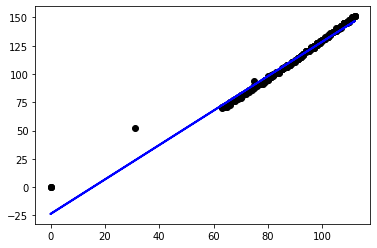

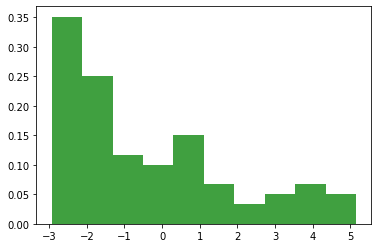

In [76]:
import matplotlib.pyplot as plt

# Plot X_train -> y_train
plt.scatter(X_train, y_train,  color='black')
plt.plot(X_train, alg.predict(X_train), color='blue', linewidth=2)

plt.xticks()
plt.yticks()
plt.show()

# Plot histogram of absolute error of |y_test - y_predicted|
plt.hist(y_test - y_predicted, 10, density=True, facecolor='g', alpha=0.75)
plt.show()


